# Notebook 3: Visualización de Resultados - Demanda Real vs. Predicción

**Objetivo:** Este notebook carga los resultados del pipeline de predicción desde BigQuery y genera un gráfico comparativo para visualizar la precisión del modelo en un período de tiempo específico.

In [1]:
# --- Celda de Carga de Datos (Versión Final Robusta: Últimos 365 días) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.oauth2 import service_account
from dotenv import load_dotenv
import os

# --- CAMBIO CLAVE: Aseguramos que estamos en el directorio raíz del proyecto ---
if os.path.basename(os.getcwd()) == 'notebooks_explicativos':
    os.chdir('../../')
print(f"Directorio de trabajo actual: {os.getcwd()}")

# --- Carga de Datos desde la tabla de predicciones en BigQuery ---
print("\nCargando datos de predicciones para los últimos 365 días...")
load_dotenv()

GCP_KEY_PATH = os.getenv("GCP_SERVICE_ACCOUNT_KEY_PATH")
PROJECT_ID = "datamanagementbi"
TABLE_ID = "gold_data.predicciones_modelo_final" 

credentials = service_account.Credentials.from_service_account_file(GCP_KEY_PATH)

# --- CONSULTA SQL MEJORADA: Últimos 365 días de datos ---
query = f"""
    WITH max_date AS (
      SELECT MAX(fecha) as max_fecha
      FROM `{PROJECT_ID}.{TABLE_ID}`
    )
    SELECT 
        CAST(fecha AS DATE) as dia,
        SUM(consumo_kwh_real) as consumo_total_real,
        SUM(consumo_kwh_predicho) as consumo_total_predicho
    FROM 
        `{PROJECT_ID}.{TABLE_ID}`
    WHERE 
        sector_nombre = 'Servicios' AND
        fecha >= DATE_SUB((SELECT max_fecha FROM max_date), INTERVAL 365 DAY)
    GROUP BY
        dia
    ORDER BY
        dia
"""
df_viz = pd.read_gbq(query, project_id=PROJECT_ID, credentials=credentials)
df_viz['dia'] = pd.to_datetime(df_viz['dia'])

print("Datos cargados.")
display(df_viz.head())

Directorio de trabajo actual: c:\Users\julic\OneDrive\EAE\DMBI\proyecto\MisProyectosGit\data-management-energy

Cargando datos de predicciones para los últimos 365 días...


C:\Users\julic\AppData\Local\Temp\ipykernel_14204\1212557265.py:45: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df_viz = pd.read_gbq(query, project_id=PROJECT_ID, credentials=credentials)


Datos cargados.


,dia,consumo_total_real,consumo_total_predicho
0,2024-08-27,2.664328e+09,2.449222e+09
1,2024-10-01,6.450800e+08,6.009186e+08
2,2024-10-02,2.866208e+09,2.457833e+09
3,2024-10-03,3.428649e+09,4.576042e+09
4,2024-10-04,3.630499e+09,4.216159e+09


**Análisis del Gráfico:** Como se puede observar, la línea de la demanda predicha (naranja) sigue muy de cerca el patrón y los valores de la demanda real (azul). Esto confirma visualmente la alta precisión del modelo (MAPE < 5%) para el sector Servicios. El modelo ha logrado capturar con éxito la estacionalidad diaria y las fluctuaciones del consumo.

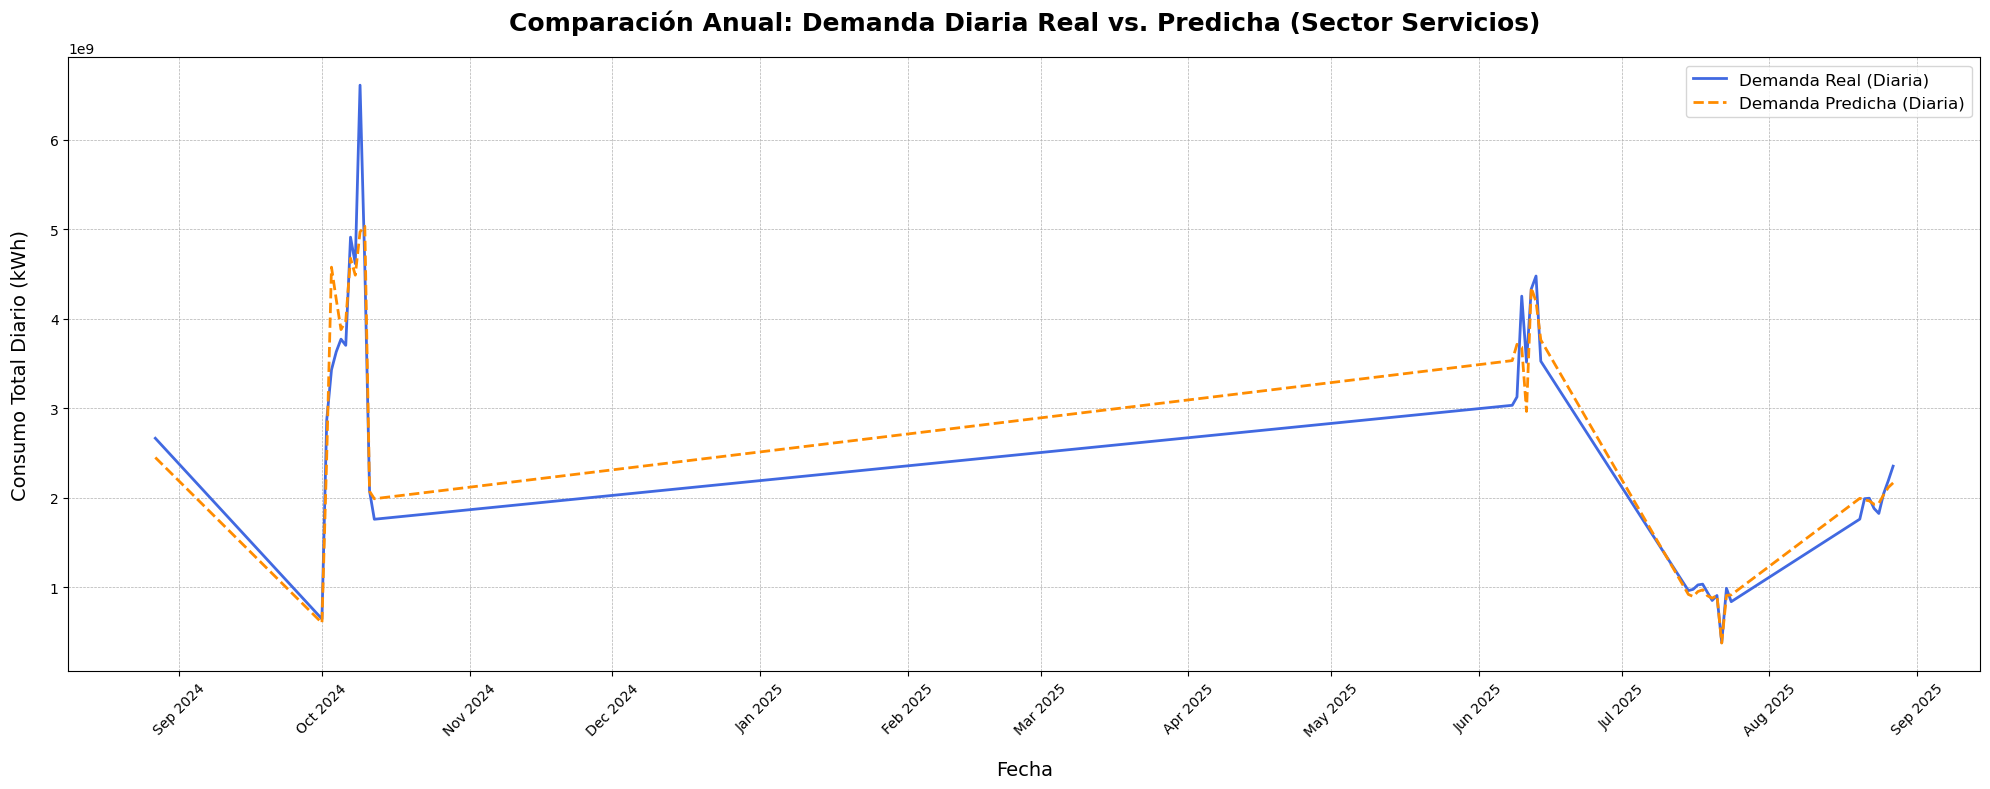

In [2]:
# --- Gráfico Mejorado: Comparación Anual de Consumo Diario ---
fig, ax = plt.subplots(figsize=(20, 8))

# Graficar los datos
ax.plot(df_viz['dia'], df_viz['consumo_total_real'], label='Demanda Real (Diaria)', color='royalblue', lw=2)
ax.plot(df_viz['dia'], df_viz['consumo_total_predicho'], label='Demanda Predicha (Diaria)', color='darkorange', lw=2, linestyle='--')

# Formateo del gráfico
ax.set_title('Comparación Anual: Demanda Diaria Real vs. Predicha (Sector Servicios)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Fecha', fontsize=14, labelpad=15)
ax.set_ylabel('Consumo Total Diario (kWh)', fontsize=14, labelpad=15)
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mejorar formato del eje X para que las fechas sean legibles
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Formato: Mes Año
ax.xaxis.set_major_locator(mdates.MonthLocator()) # Poner una marca por cada mes
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()